Global Experiment Setup

In [19]:
import mlflow
import warnings


# Set the MLflow tracking URI to a new SQLite URI
mlflow.set_tracking_uri("sqlite:///new_mlflow.db")
mlflow.set_experiment("Dummy_Experiment")

<Experiment: artifact_location='/Users/arham/Downloads/Projects/03-Experiments/mlruns/5', creation_time=1714113606309, experiment_id='5', last_update_time=1714113606309, lifecycle_stage='active', name='Dummy_Experiment', tags={}>

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.metrics import accuracy_score


def load_data(path):
    df = pd.read_csv(path)
    train_df, test_df = train_test_split(df, test_size=0.35, random_state=42)
    train_df, val_df,  = train_test_split(train_df, test_size=0.20, random_state=42)
    train_df = train_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    test_df = test_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    val_df = val_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    return train_df, val_df, test_df

def encode_target(train):
    target_key = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4,'Obesity_Type_II' : 5, 'Obesity_Type_III': 6}
    train['NObeyesdad'] = train['NObeyesdad'].map(target_key)
    return train

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Male':0, 'Female':1})

def datatypes(train):
    train['Weight'] = train['Weight'].astype(float)
    train['Age'] = train['Age'].astype(float)
    train['Height'] = train['Height'].astype(float)
    return train

# def age_binning(train_df):
#     # train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[0, 20, 30, 40, 50, train_df['Age'].max()], labels=['0-20', '21-30', '31-40', '41-50', '50+'])
#     train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[0, 20, 30, 40, 50, train_df['Age'].max()], labels=[1, 2, 3, 4, 5])
#     train_df['Age_Group'] = train_df['Age_Group'].astype(int)
#     return train_df

def age_binning(df):
    age_groups = []
    for age in df['Age']:
        if age <= 20:
            age_group = 1
        elif age <= 30:
            age_group = 2
        elif age <= 40:
            age_group = 3
        elif age <= 50:
            age_group = 4
        else:
            age_group = 5
        age_groups.append(age_group)
    df['Age_Group'] = age_groups
    return df

def age_scaling_log(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    train_df['Log_Age'] = np.log1p(train_df['Age'])
    return train_df

def age_scaling_minmax(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    scaler_age = MinMaxScaler()
    train_df['Scaled_Age'] = scaler_age.fit_transform(train_df['Age'].values.reshape(-1, 1))
    return train_df, scaler_age

def weight_scaling_log(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    train_df['Log_Weight'] = np.log1p(train_df['Weight'])
    return train_df

def weight_scaling_minmax(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    scaler_weight = MinMaxScaler()
    train_df['Scaled_Weight'] = scaler_weight.fit_transform(train_df['Weight'].values.reshape(-1, 1))
    return train_df, scaler_weight

def height_scaling_log(train_df):
    train_df['Log_Height'] = np.log1p(train_df['Height'])
    return train_df

def height_scaling_minmax(train_df):
    scaler_height = MinMaxScaler()
    train_df['Scaled_Height'] = scaler_height.fit_transform(train_df['Height'].values.reshape(-1, 1))
    return train_df, scaler_height

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Female':1, 'Male':0})
    return train

def fix_binary_columns(train):
    Binary_Cols = ['family_history_with_overweight','FAVC', 'SCC','SMOKE']
    # if yes then 1 else 0
    for col in Binary_Cols:
        train[col] = train[col].map({'yes': 1, 'no': 0})
        # column datatype integer
        train[col] = train[col].astype(int)
    return train

def freq_cat_cols(train):
    # One hot encoding
    cat_cols = ['CAEC', 'CALC']
    for col in cat_cols:
        train[col] = train[col].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    return train

def Mtrans(train):
    """
    Public_Transportation    8692
    Automobile               1835
    Walking                   231
    Motorbike                  19
    Bike                       16
    """
    # train['MTRANS'] = train['MTRANS'].map({'Public_Transportation': 3, 'Automobile': 5, 'Walking': 1, 'Motorbike': 4, 'Bike': 2})
    # dummify column
    train = pd.get_dummies(train, columns=['MTRANS'])
    # convert these columns to integer
    train['MTRANS_Automobile'] = train['MTRANS_Automobile'].astype(int)
    train['MTRANS_Walking'] = train['MTRANS_Walking'].astype(int)
    train['MTRANS_Motorbike'] = train['MTRANS_Motorbike'].astype(int)
    train['MTRANS_Bike'] = train['MTRANS_Bike'].astype(int)
    train['MTRANS_Public_Transportation'] = train['MTRANS_Public_Transportation'].astype(int)
    return train


def other_features(train):
    train['BMI'] = train['Weight'] / (train['Height'] ** 2)
    # train['Age'*'Gender'] = train['Age'] * train['Gender']
    polynomial_features = PolynomialFeatures(degree=2)
    X_poly = polynomial_features.fit_transform(train[['Age', 'BMI']])
    poly_features_df = pd.DataFrame(X_poly, columns=['Age^2', 'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'])
    train = pd.concat([train, poly_features_df], axis=1)
    return train


def test_pipeline(test, scaler_age, scaler_weight, scaler_height):
    test = datatypes(test)
    test = encode_target(test)
    test = age_binning(test)
    test = age_scaling_log(test)
    test['Scaled_Age'] = scaler_age.transform(test['Age'].values.reshape(-1, 1))
    test = weight_scaling_log(test)
    test['Scaled_Weight'] = scaler_weight.transform(test['Weight'].values.reshape(-1, 1))
    test = height_scaling_log(test)
    test['Scaled_Height'] = scaler_height.transform(test['Height'].values.reshape(-1, 1))
    test = make_gender_binary(test)
    test = fix_binary_columns(test)
    test = freq_cat_cols(test)
    test = Mtrans(test)
    test = other_features(test)

    return test

def train_model(params, X_train, y_train):
    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(params, lgb_train, num_boost_round=1000)
    return model

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred = [np.argmax(y) for y in y_pred]
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

def objective(trial, X_train, y_train):
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 0.95),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 0.95),
        'verbosity': -1
    }

    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = train_model(params, X_tr, y_tr)
        accuracy = evaluate_model(model, X_val, y_val)
        scores.append(accuracy)

    return np.mean(scores)

def optimize_hyperparameters(X_train, y_train, n_trials=2):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials)
    return study.best_params


In [21]:

path = '/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building/train.csv'
train_df, val_df, test_df = load_data(path)

train_df = datatypes(train_df)
train_df = encode_target(train_df)
train_df = age_binning(train_df)
train_df, scaler_age = age_scaling_minmax(train_df)
train_df = age_scaling_log(train_df)
train_df, scaler_weight = weight_scaling_minmax(train_df)
train_df = weight_scaling_log(train_df)
train_df, scaler_height = height_scaling_minmax(train_df)
train_df = height_scaling_log(train_df)
train_df = make_gender_binary(train_df)
train_df = fix_binary_columns(train_df)
train_df = freq_cat_cols(train_df)
train_df = Mtrans(train_df)
train_df = other_features(train_df)

val_df = test_pipeline(val_df, scaler_age, scaler_weight, scaler_height)
test_df = test_pipeline(test_df, scaler_age, scaler_weight, scaler_height)

Target = 'NObeyesdad'
features = train_df.columns.drop(Target)

features = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'Age_Group', 
       'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'Age^2',
       'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'] 
#'Scaled_Age', 'Log_Age', 'Scaled_Weight', 'Log_Weight', 'Scaled_Height', 'Log_Height',

X_train = train_df[features]
y_train = train_df[Target]
X_val = val_df[features]
y_val = val_df[Target]
X_test = test_df[features]
y_test = test_df[Target]

# save X_train, y_train, X_val, X_test, y_test


Baseline Experiment

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import mlflow
import warnings
warnings.filterwarnings("ignore")

mlflow.sklearn.autolog(disable =True)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import learning_curve

with mlflow.start_run(run_name="Dummy_Classifier_Decision_Tree"):
    # Calculate instances of each class in training and validation sets
    class_counts_train = [y_train[y_train == i].count()/y_train.count() for i in range(7)]
    class_counts_val = [y_val[y_val == i].count()/y_val.count() for i in range(7)]
    # Calculate relative frequencies by subtracting class counts in validation set from training set
    # and then dividing them by class counts in training set
    target_drift = [(train_count - val_count) for train_count, val_count in zip(class_counts_train, class_counts_val)]
    print(f"Target Drift For Each Class {target_drift}")

    # Log the relative frequencies to MLflow
    mlflow.log_params({'Target_Drift_' + str(i): freq for i, freq in enumerate(target_drift)})


    # Define Decision Tree classifier with class weights
    dt_classifier = DecisionTreeClassifier()
    
    # Perform cross-validation on scaled training data
    cv_scores_dt = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
    # Print cross-validation scores
    print("Cross-validation Scores (Decision Tree):", cv_scores_dt)
    print("Mean CV Accuracy (Decision Tree):", cv_scores_dt.mean())
    # Train the Decision Tree classifier on the full scaled training set
    dt_classifier.fit(X_train, y_train)
    # Predict on the validation set using Decision Tree
    y_val_pred_dt = dt_classifier.predict(X_val)
    # Evaluate performance of Decision Tree
    accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
    precision_dt = precision_score(y_val, y_val_pred_dt, average='weighted')
    recall_dt = recall_score(y_val, y_val_pred_dt, average='weighted')
    f1 = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)
    print("\nAccuracy (Decision Tree):", accuracy_dt)
    print("Precision (Decision Tree):", precision_dt)
    print("Recall (Decision Tree):", recall_dt)
    print("F1 (Decision Tree):", f1)
    # Log the evaluation metrics to the MLflow run
    mlflow.log_metric('accuracy', accuracy_dt)
    mlflow.log_metric('precision', precision_dt)
    mlflow.log_metric('recall', recall_dt)
    mlflow.log_metric('f1', f1)

    # Calculate precision, recall, fscore, support for each class
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(y_val, y_val_pred_dt, average=None)
    for i in range(len(recall_per_class)):
        print(f"Recall for class {i}: {recall_per_class[i]}")
        mlflow.log_metric(f'recall_class_{i}', recall_per_class[i])

    # Log the learning curve
    train_sizes, train_scores, val_scores = learning_curve(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    learning_curve_data = pd.DataFrame({'train_sizes': train_sizes, 'train_scores_mean': train_scores_mean, 'val_scores_mean': val_scores_mean})
    learning_curve_data.to_csv("learning_curve_data.csv", index=False)
    mlflow.log_artifact("learning_curve_data.csv", artifact_path="learning_curves")

    # Log the trained model to the MLflow run
    mlflow.sklearn.log_model(dt_classifier, 'model')
    mlflow.set_tag('experiments', 'Arham A.')
    mlflow.set_tag('model_name', 'Decision Trees')
    mlflow.set_tag('preprocessing', 'None')

Target Drift For Each Class [0.004943133623686147, 0.011990707821925795, -0.0087675011457998, -0.001077949504617301, -0.017190035106736085, -0.00032756263090533144, 0.01042920694244659]
Cross-validation Scores (Decision Tree): [0.84298286 0.8360352  0.83835109 0.83549583 0.8313253 ]
Mean CV Accuracy (Decision Tree): 0.8368380566123831

Accuracy (Decision Tree): 0.8366061504260838
Precision (Decision Tree): 0.8359576346912269
Recall (Decision Tree): 0.8366061504260838
F1 (Decision Tree): 0.8362817668317138
Recall for class 0: 0.879746835443038
Recall for class 1: 0.7967914438502673
Recall for class 2: 0.6805970149253732
Recall for class 3: 0.6930091185410334
Recall for class 4: 0.7909738717339667
Recall for class 5: 0.930622009569378
Recall for class 6: 0.9960474308300395


In [25]:
!mlflow ui --backend-store-uri "sqlite:////Users/arham/Downloads/Projects/03-Experiments/new_mlflow.db"

[2024-04-26 10:05:04 -0400] [32000] [INFO] Starting gunicorn 21.2.0
[2024-04-26 10:05:04 -0400] [32000] [INFO] Listening at: http://127.0.0.1:5000 (32000)
[2024-04-26 10:05:04 -0400] [32000] [INFO] Using worker: sync
[2024-04-26 10:05:04 -0400] [32001] [INFO] Booting worker with pid: 32001
[2024-04-26 10:05:04 -0400] [32002] [INFO] Booting worker with pid: 32002
[2024-04-26 10:05:04 -0400] [32003] [INFO] Booting worker with pid: 32003
[2024-04-26 10:05:04 -0400] [32004] [INFO] Booting worker with pid: 32004
^C
[2024-04-26 10:14:41 -0400] [32000] [INFO] Handling signal: int
[2024-04-26 10:14:42 -0400] [32004] [INFO] Worker exiting (pid: 32004)
[2024-04-26 10:14:42 -0400] [32002] [INFO] Worker exiting (pid: 32002)
[2024-04-26 10:14:42 -0400] [32003] [INFO] Worker exiting (pid: 32003)
[2024-04-26 10:14:42 -0400] [32001] [INFO] Worker exiting (pid: 32001)


## without ml flow

In [17]:

path = '/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building/train.csv'
train_df, val_df, test_df = load_data(path)

train_df = datatypes(train_df)
train_df = encode_target(train_df)
train_df = age_binning(train_df)
train_df, scaler_age = age_scaling_minmax(train_df)
train_df = age_scaling_log(train_df)
train_df, scaler_weight = weight_scaling_minmax(train_df)
train_df = weight_scaling_log(train_df)
train_df, scaler_height = height_scaling_minmax(train_df)
train_df = height_scaling_log(train_df)
train_df = make_gender_binary(train_df)
train_df = fix_binary_columns(train_df)
train_df = freq_cat_cols(train_df)
train_df = Mtrans(train_df)
train_df = other_features(train_df)

val_df = test_pipeline(val_df, scaler_age, scaler_weight, scaler_height)
test_df = test_pipeline(test_df, scaler_age, scaler_weight, scaler_height)

Target = 'NObeyesdad'
features = train_df.columns.drop(Target)

features = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'Age_Group', 
       'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'Age^2',
       'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2']
#'Scaled_Age', 'Log_Age', 'Scaled_Weight', 'Log_Weight', 'Scaled_Height', 'Log_Height',

X_train = train_df[features]
y_train = train_df[Target]
X_val = val_df[features]
y_val = val_df[Target]
X_test = test_df[features]
y_test = test_df[Target]

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

# Calculate instances of each class in training and validation sets
class_counts_train = [y_train[y_train == i].count()/y_train.count() for i in range(7)]
class_counts_val = [y_val[y_val == i].count()/y_val.count() for i in range(7)]
# Calculate relative frequencies by subtracting class counts in validation set from training set
# and then dividing them by class counts in training set
target_drift = [(train_count - val_count) for train_count, val_count in zip(class_counts_train, class_counts_val)]
print(f"Target Drift For Each Class {target_drift}")

# Define Decision Tree classifier with class weights
dt_classifier = DecisionTreeClassifier()

# Perform cross-validation on scaled training data
cv_scores_dt = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
# Print cross-validation scores
print("Cross-validation Scores (Decision Tree):", cv_scores_dt)
print("Mean CV Accuracy (Decision Tree):", cv_scores_dt.mean())
# Train the Decision Tree classifier on the full scaled training set
dt_classifier.fit(X_train, y_train)
# Predict on the validation set using Decision Tree
y_val_pred_dt = dt_classifier.predict(X_val)
# Evaluate performance of Decision Tree
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
precision_dt = precision_score(y_val, y_val_pred_dt, average='weighted')
recall_dt = recall_score(y_val, y_val_pred_dt, average='weighted')
f1 = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)
print("\nAccuracy (Decision Tree):", accuracy_dt)
print("Precision (Decision Tree):", precision_dt)
print("Recall (Decision Tree):", recall_dt)
print("F1 (Decision Tree):", f1)

# Calculate precision, recall, fscore, support for each class
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(y_val, y_val_pred_dt, average=None)
for i in range(len(recall_per_class)):
    print(f"Recall for class {i}: {recall_per_class[i]}")

# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
learning_curve_data = pd.DataFrame({'train_sizes': train_sizes, 'train_scores_mean': train_scores_mean, 'val_scores_mean': val_scores_mean})
learning_curve_data.to_csv("learning_curve_data.csv", index=False)

# Log the trained model
dt_classifier.fit(X_train, y_train)


Target Drift For Each Class [0.004943133623686147, 0.011990707821925795, -0.0087675011457998, -0.001077949504617301, -0.017190035106736085, -0.00032756263090533144, 0.01042920694244659]
Cross-validation Scores (Decision Tree): [0.83974062 0.8360352  0.83696156 0.83178869 0.83178869]
Mean CV Accuracy (Decision Tree): 0.8352629529769772

Accuracy (Decision Tree): 0.8310485364949981
Precision (Decision Tree): 0.8298777540644694
Recall (Decision Tree): 0.8310485364949981
F1 (Decision Tree): 0.8304627326390563
Recall for class 0: 0.8765822784810127
Recall for class 1: 0.7887700534759359
Recall for class 2: 0.6656716417910448
Recall for class 3: 0.6930091185410334
Recall for class 4: 0.7790973871733967
Recall for class 5: 0.930622009569378
Recall for class 6: 0.9940711462450593


DecisionTreeClassifier()

In [28]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

ExplainerDashboard(
    ClassifierExplainer(
        DecisionTreeClassifier().fit(X_train, y_train),
        X_test, y_test
    )
).run()

Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up t

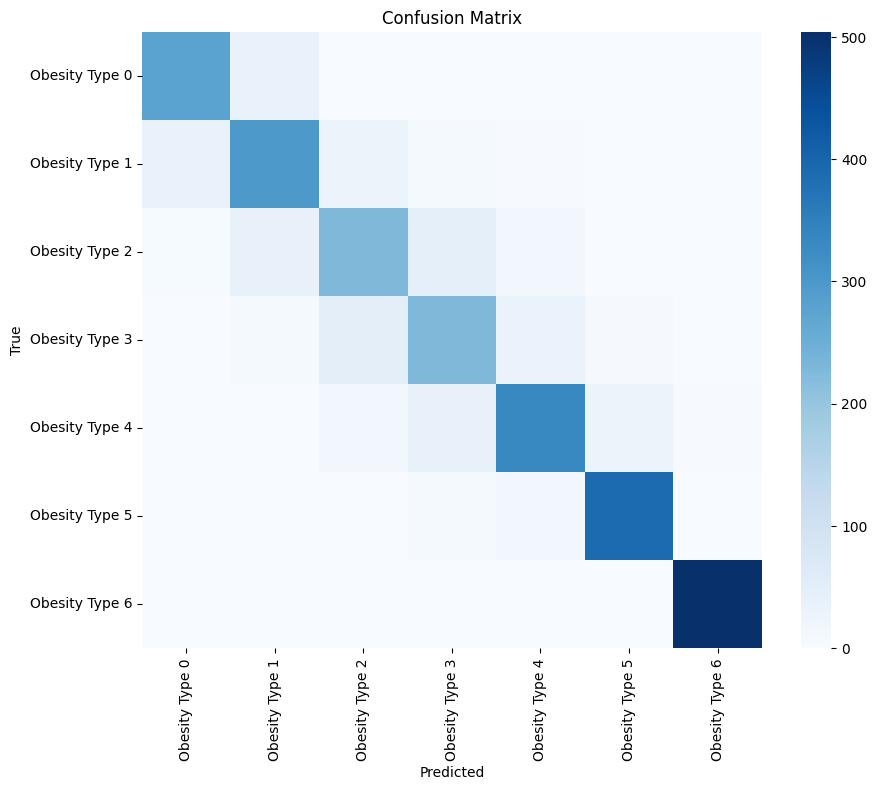

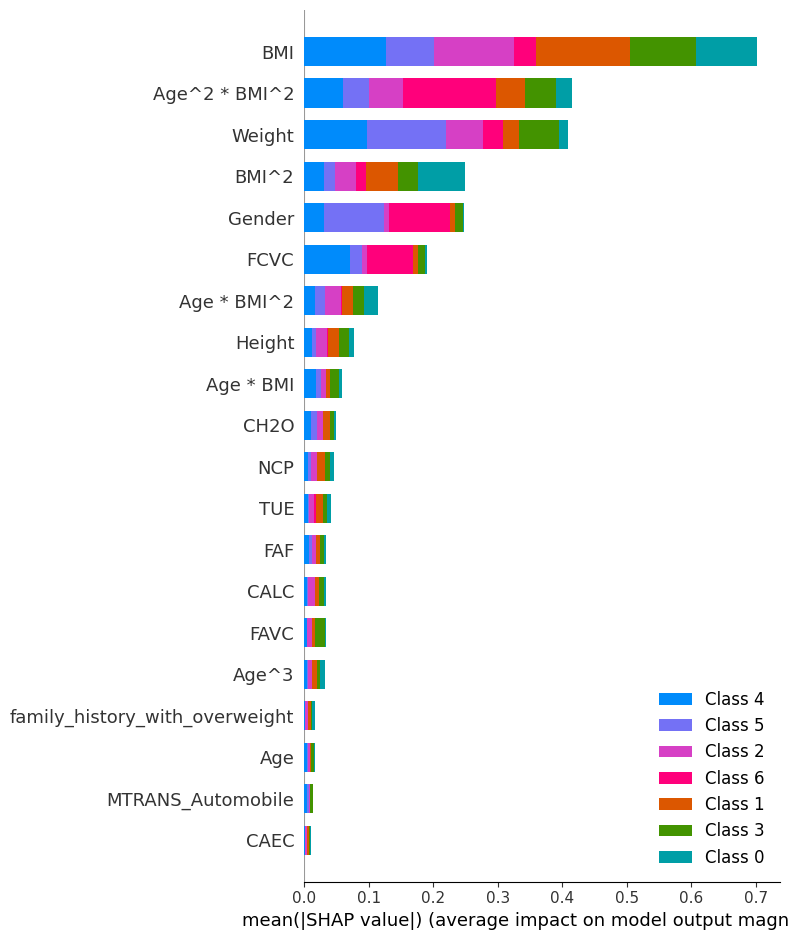

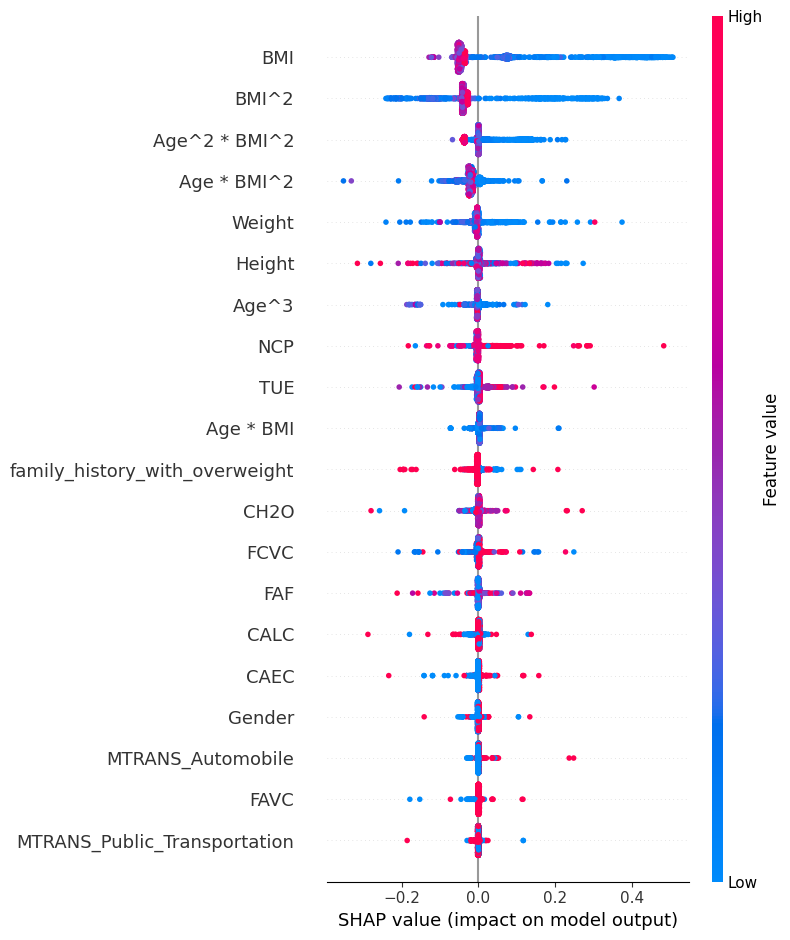

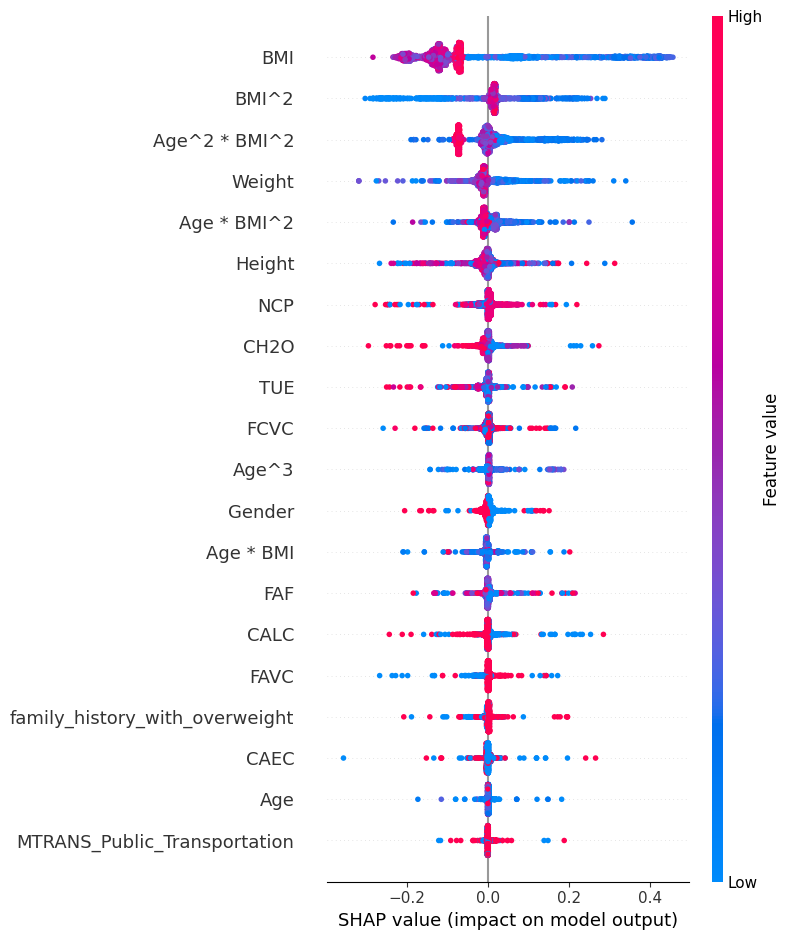

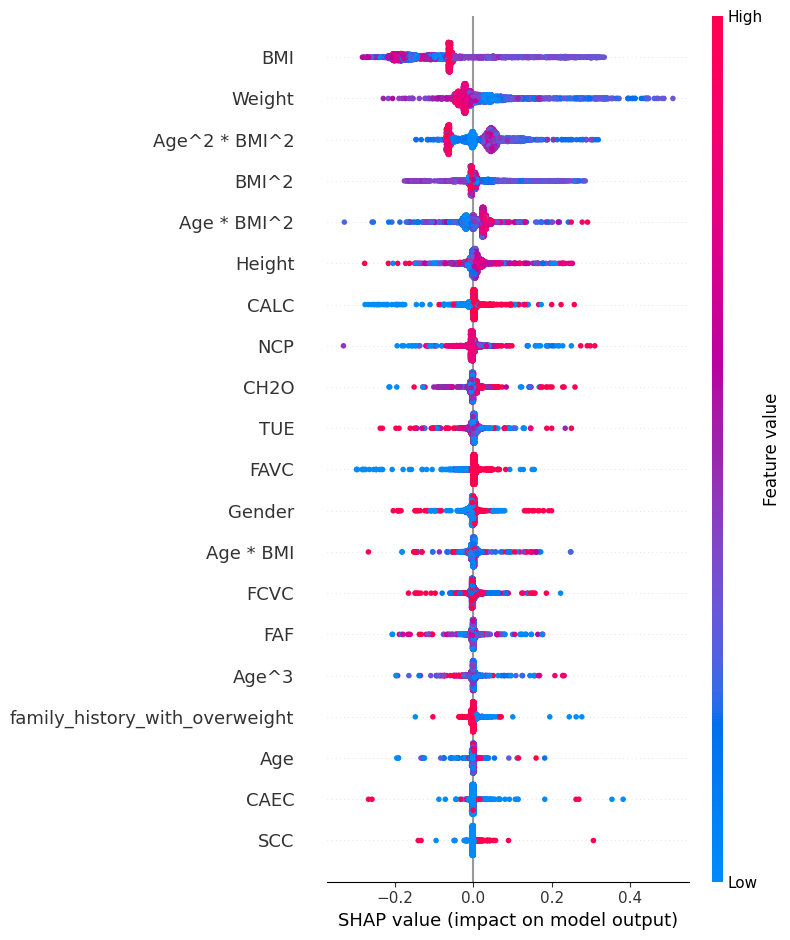

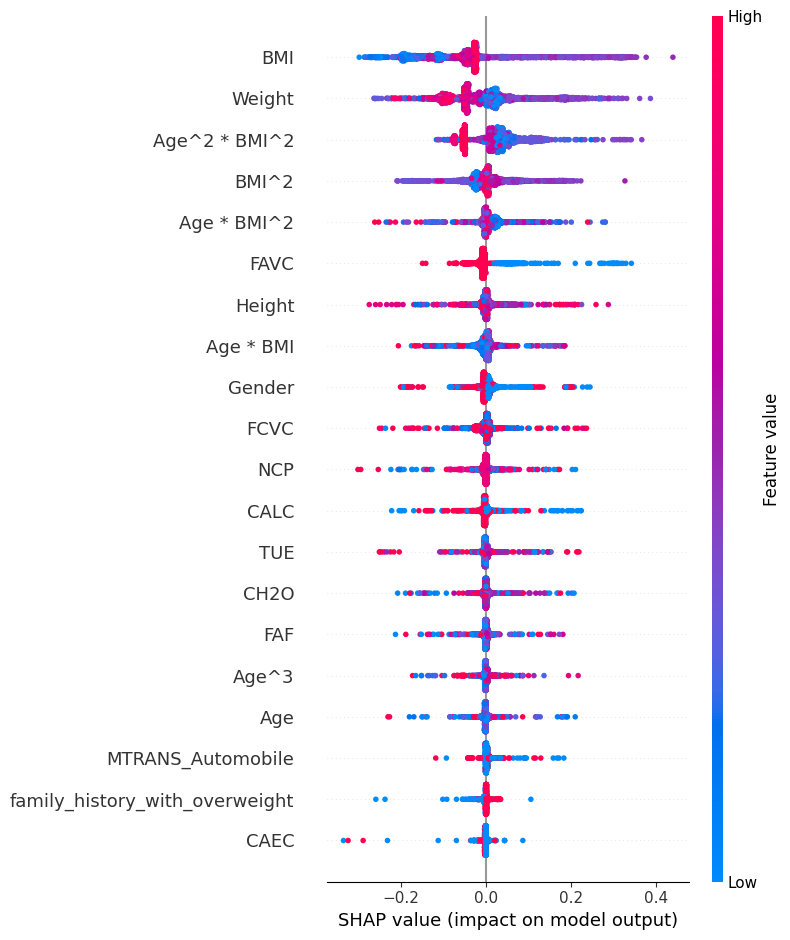

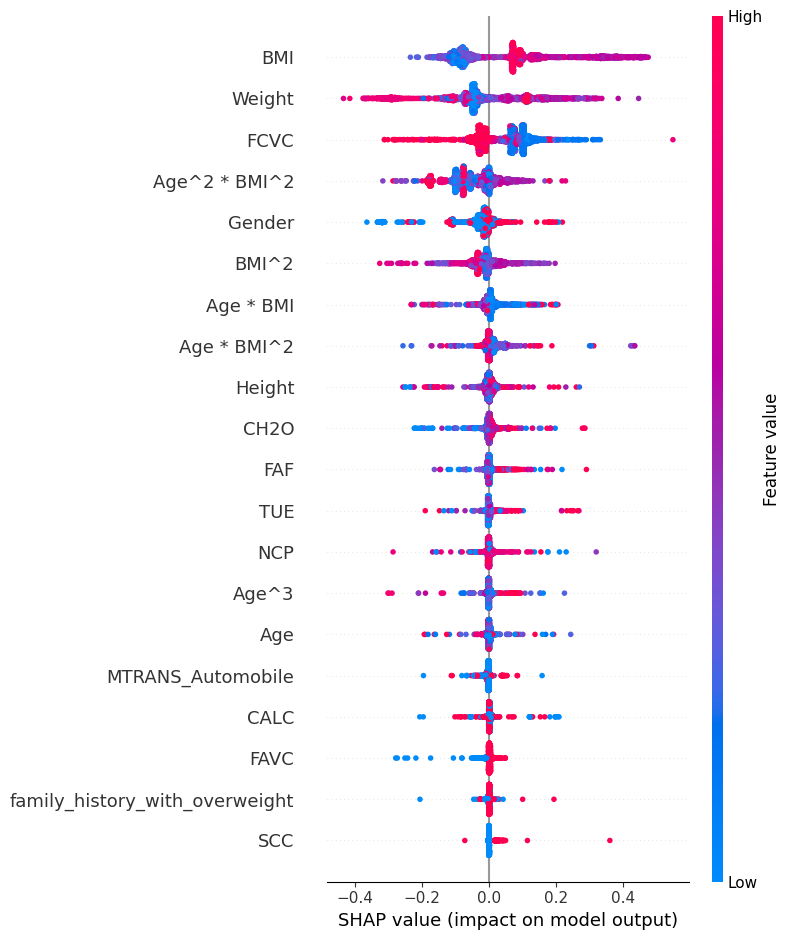

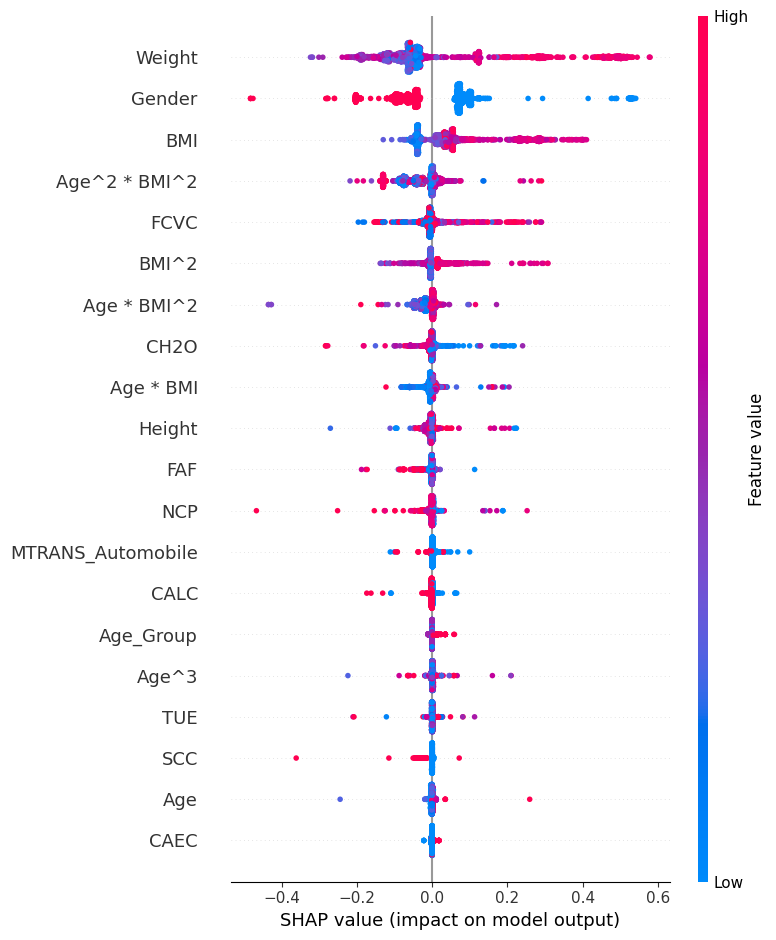

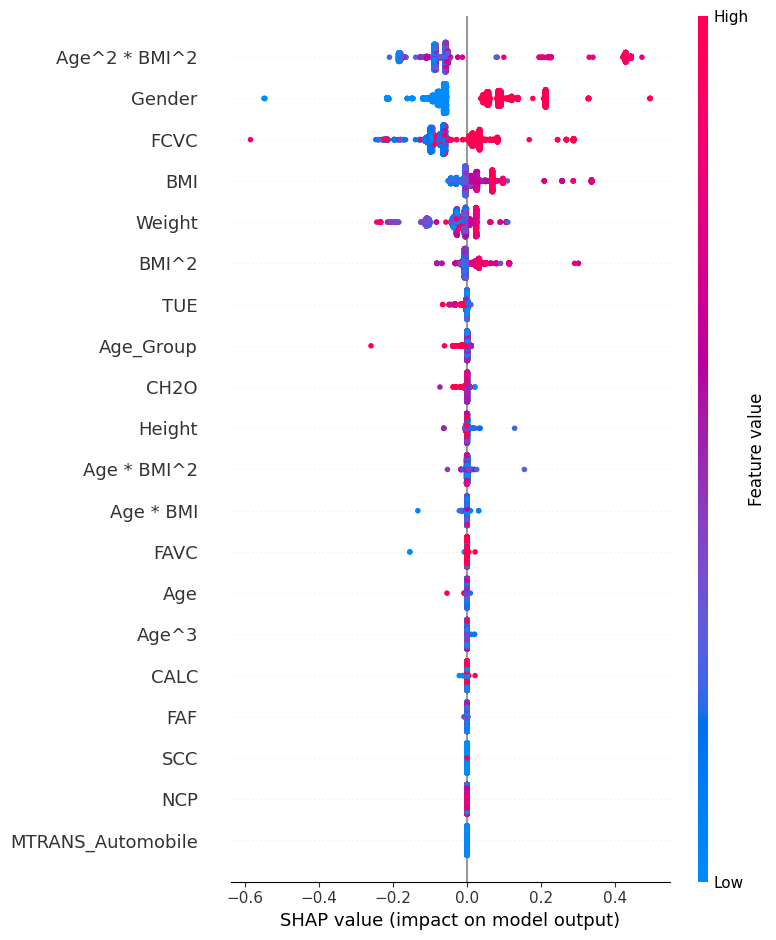

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cm(model, X_val, y_val):
# Predict on the validation set using Decision Tree
    y_val_pred_dt = model.predict(X_val)

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_val_pred_dt)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", xticklabels=["Obesity Type 0", "Obesity Type 1", "Obesity Type 2", "Obesity Type 3", "Obesity Type 4", "Obesity Type 5", "Obesity Type 6"], yticklabels=["Obesity Type 0", "Obesity Type 1", "Obesity Type 2", "Obesity Type 3", "Obesity Type 4", "Obesity Type 5", "Obesity Type 6"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

cm(dt_classifier, X_val, y_val)


# global shap plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

#local shap plot for each class

shap.summary_plot(shap_values[0], X_val)
shap.summary_plot(shap_values[1], X_val)
shap.summary_plot(shap_values[2], X_val)
shap.summary_plot(shap_values[3], X_val)
shap.summary_plot(shap_values[4], X_val)
shap.summary_plot(shap_values[5], X_val)
shap.summary_plot(shap_values[6], X_val)


model = dt_classifier


In [8]:
# multi_explainer = shap.TreeExplainer(dt_classifier)
# multi_shap_values = multi_explainer.shap_values(X_train)


# import shap

# # Choose a particular instance for which you want to visualize the SHAP values
# instance_index = 0  # Change this to the index of the instance you want to visualize

# # Extract the corresponding feature values for the instance
# instance_features = X_train.iloc[[instance_index]]

# # Create a SHAP force plot for all classes
# for class_index, shap_values_class in enumerate(multi_shap_values):
#     print(f"SHAP Force Plot for Class {class_index}:")
#     shap.force_plot(
#         multi_explainer.expected_value[class_index],  # The expected value of the model for this class
#         shap_values_class[instance_index],  # SHAP values for the chosen instance and class
#         instance_features,  # Feature values for the chosen instance
#         feature_names=X_train.columns  # Feature names
#     )




In [9]:
X_train.values[i]

array([0.00000000e+00, 2.35726480e+01, 1.78653200e+00, 9.79715980e+01,
       1.00000000e+00, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 2.00000000e+00, 0.00000000e+00,
       6.54316000e-01, 1.69879000e-01, 0.00000000e+00, 2.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 3.06957743e+01, 1.00000000e+00, 2.35726480e+01,
       3.06957743e+01, 5.55669734e+02, 7.23580682e+02, 9.42230559e+02])

In [13]:
import shap
import matplotlib.pyplot as plt

# Train the Decision Tree classifier on the full scaled training set
dt_classifier.fit(X_train, y_train)

# Create a SHAP explainer for the trained model
explainer = shap.TreeExplainer(dt_classifier)

# Calculate SHAP values for the validation dataset
shap_values = explainer.shap_values(X_val)

# Choose an index for which you want to generate the force plot
i = 23

# Generate the SHAP force plot for the selected instance from the validation dataset
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_val.iloc[i])

# Display the plot
plt.show()


In [93]:
plt.show()

In [64]:
multi_shap_values

[array([[-1.15315677e-04,  5.98816770e-03, -3.91502174e-04, ...,
          1.27419315e-04, -2.27329109e-02,  5.98936360e-02],
        [-1.53070719e-03,  5.00490249e-03,  3.29028834e-04, ...,
          3.45020254e-04, -1.21677316e-02, -3.06278504e-03],
        [-6.37332524e-04,  3.82470660e-04, -3.16620934e-03, ...,
          3.35457992e-03,  6.11855973e-03,  3.65583370e-02],
        ...,
        [-1.44812732e-03,  6.07276021e-03, -7.74321445e-04, ...,
         -7.33341779e-03, -1.42962966e-02, -7.55151596e-03],
        [-1.24319957e-03, -1.30814404e-03,  5.63131594e-04, ...,
         -1.52393616e-03, -1.88174927e-02, -4.79643883e-03],
        [-5.99613736e-05, -1.33826355e-03, -3.25948219e-04, ...,
         -1.18450374e-03, -2.17279134e-02, -4.37720869e-03]]),
 array([[-9.11774391e-04, -5.98437429e-03, -4.25787203e-04, ...,
          1.40505729e-03,  2.57711926e-02,  7.87297664e-03],
        [ 1.15579969e-02, -6.06599141e-03,  8.56137466e-05, ...,
         -1.06707988e-03,  7.06632282e

In [83]:
# list of misclassified instances for each class
def misclassified_instances(model, X_val, y_val):
    y_val_pred = model.predict(X_val)
    misclassified_instances_dict = {}
    for i in range(7):
        misclassified_instances_dict[i] = X_val[(y_val == i) & (y_val_pred != i)]
    return misclassified_instances_dict

misclassified_instances_dict = misclassified_instances(dt_classifier, X_val, y_val)
misclassified_instances_dict.keys()
misclassified_instances_dict[2]
# list of indexes of misclassified instances for misclassified_instances_dict[2]
misclassified_instances_dict[2].index

# force plot for an instance with index k
k = misclassified_instances_dict[2].index[9]
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][k], X_val.iloc[k], matplotlib=matplotlib)

TypeError: list indices must be integers or slices, not tuple

In [47]:
explainer.expected_value

array([0.12202353, 0.15056055, 0.11535254, 0.12081905, 0.13879366,
       0.15454461, 0.19790605])

In [48]:
shap_values[2]

array([[-0.00076957, -0.00038365,  0.01212495, ..., -0.00298406,
         0.02590897,  0.00815275],
       [-0.00366098, -0.00714094, -0.00697701, ...,  0.00061958,
        -0.11983236, -0.01691312],
       [ 0.00236045, -0.00166804,  0.14283223, ..., -0.0068011 ,
        -0.0096861 ,  0.02442264],
       ...,
       [-0.01325623,  0.00664043, -0.04911283, ...,  0.00552119,
         0.02345671, -0.00089425],
       [-0.00402501,  0.00223538,  0.00763188, ..., -0.00963543,
         0.00979565, -0.01340146],
       [ 0.00346818,  0.00127306, -0.00771543, ...,  0.0015561 ,
        -0.00992974, -0.05269342]])

In [50]:
X_val.iloc[2]

Gender                              1.000000
Age                                17.000000
Height                              1.550000
Weight                             55.000000
family_history_with_overweight      1.000000
FAVC                                1.000000
FCVC                                2.000000
NCP                                 3.000000
CAEC                                1.000000
SMOKE                               0.000000
CH2O                                2.000000
SCC                                 0.000000
FAF                                 2.000000
TUE                                 1.000000
CALC                                1.000000
Age_Group                           1.000000
MTRANS_Automobile                   0.000000
MTRANS_Bike                         0.000000
MTRANS_Motorbike                    0.000000
MTRANS_Public_Transportation        1.000000
MTRANS_Walking                      0.000000
BMI                                22.892820
Age^2     